In [13]:
import numpy as np
import subprocess
import os

DELETE_TEMP = False

ORCA_PATH = "/home/gui/orca_6_0_1/"
ORCA_EXEC = ORCA_PATH+"orca"

SSCC_INPUT = "acetamide_sscc.inp"
SSCC_OUTPUT = "acetamide_sscc.property.txt"
NMR_INPUT = "acetamide_nmr.inp"
NMR_OUTPUT = "acetamide_nmr.property.txt"
NMR_SPEC_INPUT = "acetamide.nmrspec"
NMR_GBW_FILE = "acetamide_nmr.gbw"
NMR_SPEC_OUTPUT = "acetamide_nmrspec.out"

# creat input file for spin-spin coupling constants 
sscc_inp = '''
!B3LYP 6-31G*

*xyz 0 1
  O          -0.46269991708219      1.26347851821489     -0.25636278872658
  N           0.71857458246431     -0.66376635191250      0.05627510754746
  C          -0.44155497151501      0.05063526848618     -0.08649725038021
  C           2.02871261396007     -0.03987380453501      0.02291345938059
  C          -1.72204540274477     -0.77251562482314     -0.02173604985495
  H           0.66014801076857     -1.66095160782806      0.19945565079693
  H           2.55818083398569     -0.16816058626330      0.97543308336928
  H           1.87254650126915      1.02501026444747     -0.15753197370456
  H           2.64664219040216     -0.45496754358063     -0.78286182010502
  H          -2.34765828014480     -0.38714532433314      0.78968161181891
  H          -2.27740323351236     -0.63290341950480     -0.95471645016362
  H          -1.55704292785082     -1.84383978836795      0.13564742002177
* 

%eprnmr
 Nuclei = all H {ssall}
end
'''

with open(SSCC_INPUT,"w") as f:
    f.write(sscc_inp)

# run orca for spin-spin couling constants
subprocess.run([ORCA_EXEC, SSCC_INPUT], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)

CompletedProcess(args=['/home/gui/orca_6_0_1/orca', 'acetamide_sscc.inp'], returncode=0)

In [14]:
# create input file for NMR shieldings
nmr_inp = '''
!B3LYP 6-31G* NMR
*xyz 0 1
  O          -0.46269991708219      1.26347851821489     -0.25636278872658
  N           0.71857458246431     -0.66376635191250      0.05627510754746
  C          -0.44155497151501      0.05063526848618     -0.08649725038021
  C           2.02871261396007     -0.03987380453501      0.02291345938059
  C          -1.72204540274477     -0.77251562482314     -0.02173604985495
  H           0.66014801076857     -1.66095160782806      0.19945565079693
  H           2.55818083398569     -0.16816058626330      0.97543308336928
  H           1.87254650126915      1.02501026444747     -0.15753197370456
  H           2.64664219040216     -0.45496754358063     -0.78286182010502
  H          -2.34765828014480     -0.38714532433314      0.78968161181891
  H          -2.27740323351236     -0.63290341950480     -0.95471645016362
  H          -1.55704292785082     -1.84383978836795      0.13564742002177
* 
'''

with open(NMR_INPUT,"w") as f:
    f.write(nmr_inp)

# run orca for NMR shieldings
subprocess.run([ORCA_EXEC, NMR_INPUT], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)

CompletedProcess(args=['/home/gui/orca_6_0_1/orca', 'acetamide_nmr.inp'], returncode=0)

In [16]:
ORCA_NMRSPC = ORCA_PATH+"orca_nmrspectrum"

# create input file for orca_nmrspectrum
nmr_spec_inp = '''
NMRShieldingFile = "acetamide_nmr"
NMRCouplingFile = "acetamide_sscc"
NMRSpecFreq = 80.00
PrintLevel = 0
NMRCoal = 1.0
NMRREF[1] 31.77
NMRREF[6] 188.10
NMREquiv
1 {6 7 8} end
2 {9 10 11} end
end
END
'''

with open(NMR_SPEC_INPUT,"w") as f:
    f.write(nmr_spec_inp)

with open(NMR_SPEC_OUTPUT,"w") as f_o:
    subprocess.run([ORCA_NMRSPC, NMR_GBW_FILE, NMR_SPEC_INPUT], stdout = f_o, stderr = subprocess.DEVNULL) # run orca_nmrspectrum (there is a bug in this version)

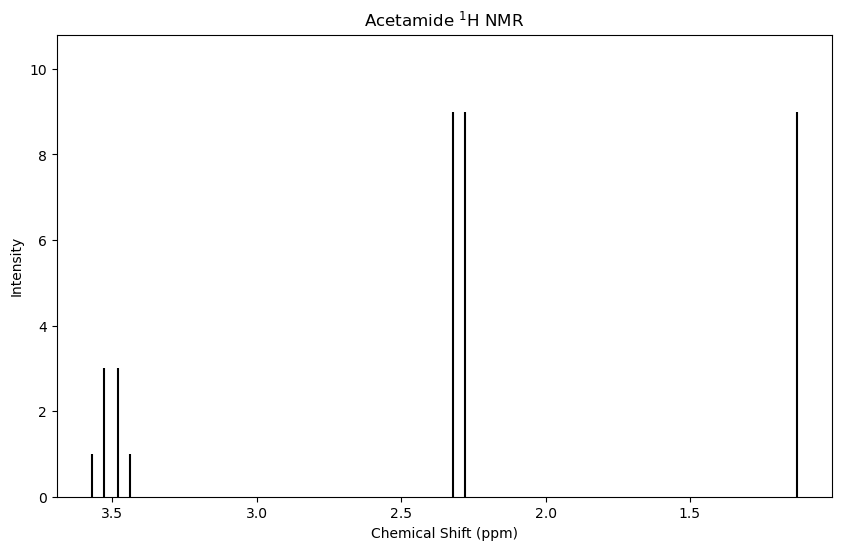

Wrong SpecType!


SystemExit: 1

In [17]:
# read hydrogen data from the output
import json

hydrogen_data = []

with open("acetamide_nmrspec_corrected.out","r") as f:
    lines = f.readlines()

inside_hydrogen_section = False
for i, line in enumerate(lines):
    if "NMR Peaks for atom type 1" in line:
        inside_hydrogen_section = True
        continue
    if inside_hydrogen_section:
        parts = line.split()        
        if len(parts) == 3:
            try:
               atom, shift_ppm, rel_intensity = int(parts[0]), float(parts[1]), float(parts[2])
               hydrogen_data.append((shift_ppm, rel_intensity))
            except ValueError:
               continue
        if "NMR Peaks for atom type" in line:
            inside_hydrogen_section = False
            break
    
if not hydrogen_data: 
    print("No hydrogen data found.")

with open("hydrogen_data.json", "w") as json_file:
    json.dump(hydrogen_data, json_file)

# plot the NMR spectrum
from importlib import reload
import ConvolutionPlot
                       
reload(ConvolutionPlot) 
from ConvolutionPlot import * 

ConvPlot(SpecType = 4, gamma = 0.0, PlotTitle = "Acetamide $^1$H NMR", 
            DataFileNames=["acetamide_nmrspec_corrected.out"])